<a href="https://colab.research.google.com/github/VSPlekhanov/TimeSeriesForecasting_analysis/blob/main/311_requests_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels as stat
from sklearn.metrics import mean_squared_error
import math

In [ ]:
data = pd.read_csv('drive/MyDrive/Colab Notebooks/311-requests.tsv', '\t')
data = data.groupby('Creation Date', as_index=False).agg('count')\
    .rename({'Status': 'Count'}, axis=1)[['Count', 'Creation Date']]
data['Creation Date'] = data['Creation Date'].apply(lambda x: x[:10])
data['Date'] = pd.to_datetime(data['Creation Date'])
dates = data['Creation Date']
data = data.drop('Creation Date', axis=1)
data.set_index('Date', inplace=True)

offset = 41
data = data[offset:]
plt.figure(figsize=(12,8))
print(len(data))
plt.plot(data)

In [ ]:
plt.figure(figsize=(12,8))

plt.plot(data[300:350])

In [ ]:
# Тест Дики-Фулера
from statsmodels.tsa.stattools import adfuller
adf, pvalue, usedlag_, nobs_, critical_values_, icbest_ = adfuller(data['Count'])
print("pvalue = ", pvalue, " если больще 0.05, временной ряд не стацонарен")

In [5]:
size = int(len(data) * 0.66)
X_train, X_test = data[:size], data[size:len(data)]
train, test = X_train, X_test

In [6]:
s = 365
prediction = data.copy()
for i in range(len(X_test)):
  prev = prediction['Count'][len(X_train) + i - s]
  prediction['Count'][len(X_train) + i] = prev

In [7]:
s = 364
prediction = data.copy()
for i in range(len(X_test)):
  prev = prediction['Count'][len(X_train) + i - s]
  prediction['Count'][len(X_train) + i] = prev

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(data, label='Данные', color='blue')
plt.plot(prediction[len(X_train):], label='Прогноз', color='red')
plt.legend()
testScore = math.sqrt(mean_squared_error(X_test, prediction[len(X_train):]))
print('Корень среднеквадратичного отклонения на проверяющей выборке: %.2f' % (testScore))

In [9]:
s = 364
prediction = X_test.copy()
for i in range(len(X_train), len(data)):
  prev = data['Count'][i - s]
  prediction['Count'][i - len(X_train)] = prev

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(data, label='Данные', color='blue')
plt.plot(prediction, label='Прогноз', color='red')
plt.legend()
testScore = math.sqrt(mean_squared_error(X_test, prediction))
print('Корень среднеквадратичного отклонения на проверяющей выборке: %.2f' % (testScore))

In [12]:
def predict_full_ES(model, data, start=len(X_train)):
  model = model.fit()
  pred = model.predict(start=start, end=len(data)-1)

  return pred

In [13]:
def predict_window_ES(modelCreationFunc, data, window, start=len(X_train)):
  curr_start = start
  pred = pd.Series(dtype='float64')
  while curr_start < len(data):
    model = modelCreationFunc(data[:curr_start])
    model = model.fit()
    pred = pred.append(model.predict(start=curr_start, end= min(curr_start + window - 1, len(data) - 1)))
    curr_start += window

  return pred

In [14]:
def analyse(full, mid, low):
  testScore = math.sqrt(mean_squared_error(X_test, full))
  print('Корень среднеквадратичного отклонения при полном прогнозе: %.2f' % (testScore))

  testScore = math.sqrt(mean_squared_error(X_test, mid))
  print('Корень среднеквадратичного отклонения при прогнозе на год: %.2f' % (testScore))

  testScore = math.sqrt(mean_squared_error(X_test, low))
  print('Корень среднеквадратичного отклонения при прогнозе на месяц: %.2f' % (testScore))

  fig, ax = plt.subplots(nrows=2, ncols=2)
  fig.set_figheight(12)
  fig.set_figwidth(15)

  ax[0][0].plot(X_test, label='Данные', color='blue')
  ax[0][0].plot(full, label='Прогноз на весь промежуток', color='red')
  ax[0][0].plot(mid, label='Прогноз на год', color='green')
  ax[0][0].plot(low, label='Прогноз на месяц', color='purple')
  ax[0][0].legend(loc='best');

  ax[0][1].plot(X_test, label='Данные', color='blue')
  ax[0][1].plot(full, label='Прогноз на весь промежуток', color='red')
  ax[0][1].legend(loc='best');

  ax[1][0].plot(X_test, label='Данные', color='blue')
  ax[1][0].plot(mid, label='Прогноз на год', color='green')
  ax[1][0].legend(loc='best');

  ax[1][1].plot(X_test, label='Данные', color='blue')
  ax[1][1].plot(low, label='Прогноз на месяц', color='purple')
  ax[1][1].legend(loc='best');

In [16]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
def get_ES_model(data):
  return ExponentialSmoothing(data, freq='D', seasonal='add', seasonal_periods=364)

In [ ]:
%%time

full = predict_full_ES(get_ES_model(X_train), data)
mid = predict_window_ES(get_ES_model, data, 365)
low = predict_window_ES(get_ES_model, data, 30)

analyse(full, mid, low)

In [ ]:
exog_arr = dates[offset:].apply(lambda x: -abs(int(x[5:7]) - 6)**3).values
ex = exog_arr.reshape((len(exog_arr), 1))

In [ ]:
def predict_full_ARIMA(model, data, start=len(X_train), exog=[]):
  model = model.fit(iprint=0)
  pred = model.predict(start=start, end=len(data)-1, exog=exog)

  return pred

In [ ]:
def get_ARIMA(data, ex):
  return SARIMAX(endog=data['Count'], order=(1,0,1),\
                 seasonal_order=(1,1,1,7),\
                 exog=ex,\
                 freq='D')

In [ ]:
def predict_window_ARIMA(modelCreationFunc, data, window, start=len(X_train), exog=[]):
  curr_start = start
  pred = pd.Series(dtype='float64')
  while curr_start < len(data):
    end = min(curr_start + window - 1, len(data) - 1)
    model = modelCreationFunc(data[:curr_start], ex[:curr_start])
    model = model.fit()
    p = model.predict(start=curr_start, end=end, exog=exog[curr_start:end+1])
    pred = pred.append(p)
    curr_start += window

  return pred

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Корень среднеквадратичного отклонения при полном прогнозе: 19.74
Корень среднеквадратичного отклонения при прогнозе на год: 21.12
Корень среднеквадратичного отклонения при прогнозе на месяц: 19.63
CPU times: user 9min 12s, sys: 28min 20s, total: 37min 33s
Wall time: 3min 55s


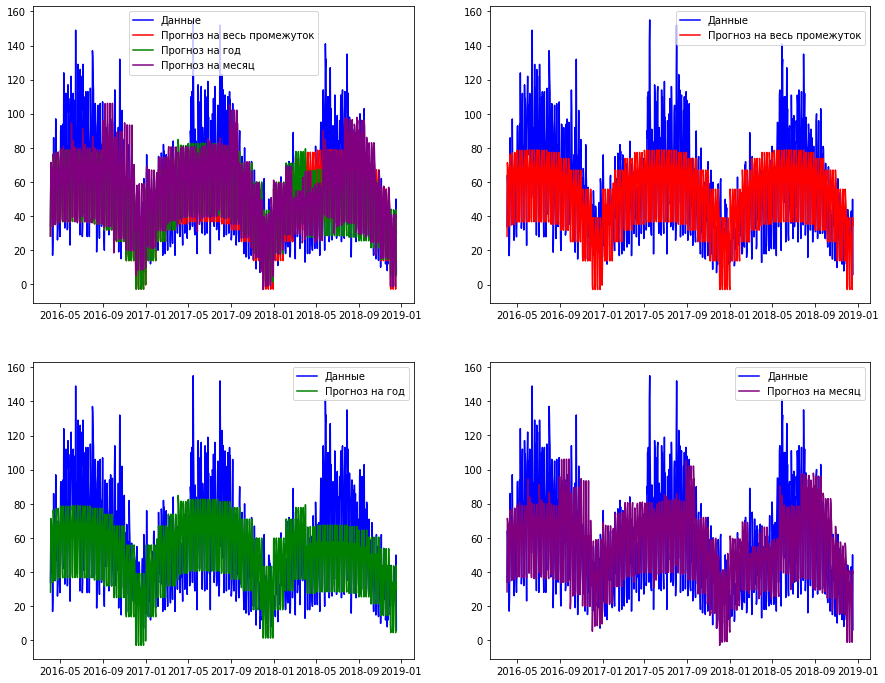

In [ ]:
%%time
from statsmodels.tsa.statespace.sarimax import SARIMAX

full = predict_full_ARIMA(get_ARIMA(X_train, ex[:len(X_train)]), data, exog=ex[len(X_train):])
mid = predict_window_ARIMA(get_ARIMA, data, 365, exog=ex)
low = predict_window_ARIMA(get_ARIMA, data, 30, exog=ex)
analyse(full, mid, low)

In [39]:
from keras.models import Sequential
from keras.layers import Dense
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from tensorflow import random

np.random.seed(1)
random.set_seed(2)

In [40]:
dataset = data.values.astype('float32')
scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

In [41]:
train_size = int(len(dataset) * 0.66)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size], dataset[train_size:len(dataset)]

In [42]:
seq_len = 25
trainX, testX, trainY, testY = [], [], [], []
for i in range(train_size - seq_len):
  trainX.append(train[i:i + seq_len, 0])
  trainY.append(train[i+seq_len, 0])

for i in range(test_size):
  testX.append(dataset[train_size + i - seq_len: train_size + i, 0])
  testY.append(test[i, 0])

trainX = np.array(trainX)
testX = np.array(testX)
trainY = np.array(trainY)
testY = np.array(testY)

In [43]:
dataX = np.concatenate((trainX, testX))
dataY = np.concatenate((trainY, testY))

In [44]:
def predict_full_train(get_model, trainX, trainY, testX, testY, count):
  pred = np.zeros((len(trainX), 1))
  for i in range(count):
    model = get_model()
    model.fit(trainX, trainY, verbose=0, epochs=100)
    pred += model.predict(trainX)

  trainPredict = pred / count
  trainPredict = scaler.inverse_transform(trainPredict)
  trainY_inverse = scaler.inverse_transform([trainY])

  trainScore = math.sqrt(mean_squared_error(trainY_inverse[0], trainPredict[:,0]))

  return trainScore

In [45]:
def predict_full(func, trainX, trainY, testX, testY, count, epochs=100):
  pred = np.zeros((len(testY), 1))
  for i in range(count):
    model = func()
    model.fit(trainX, trainY, verbose=0, epochs=epochs)
    pred += model.predict(testX)

  testPredict = pred / count
  testPredict = scaler.inverse_transform(testPredict)
  testY_inverse = scaler.inverse_transform([testY])

  testScore = math.sqrt(mean_squared_error(testY_inverse[0], testPredict[:,0]))
  return testPredict, testScore

In [46]:
def predict_parts(model, trainX, trainY, testX, testY, window, epochs):
  dataX = np.concatenate((trainX, testX))
  dataY = np.concatenate((trainY, testY))

  parts_count = int(len(testY) / window)
  parts = []
  for i in range(parts_count):
    parts += [testX[i * window:(i + 1) * window]]
  if parts_count * window < len(testX):
    parts += [testX[parts_count * window:]]
  
  pred = np.empty((0, 1))

  for i in range(len(parts)):
    curr_len = len(trainX) + window * i
    prev_len = 0
    
    model.fit(dataX[prev_len:curr_len], dataY[prev_len:curr_len], verbose=0, epochs=epochs)
    pred = np.concatenate(\
        (pred, model.predict(dataX[curr_len:curr_len + min(window, len(dataX) - curr_len)])))
    prev_len = curr_len
  testPredict = scaler.inverse_transform(pred)
  testY_inverse = scaler.inverse_transform([testY])

  testScore = math.sqrt(mean_squared_error(testY_inverse[0], testPredict[:,0]))
  return testPredict, testScore

In [47]:
def get_FFNN_model():
  model = Sequential()
  model.add(Dense(256, input_dim=seq_len, activation='relu'))
  model.add(Dense(256, activation='relu'))
  model.add(Dense(1))  
  model.compile(loss='mean_squared_error', optimizer='adam', metrics = ['acc'])
  return model

In [ ]:
%%time
predict_full_train(get_FFNN_model, trainX, trainY, testX, testY, 1)

In [ ]:
%%time
pred = predict_parts(get_FFNN_model(), trainX, trainY, testX, testY, 365, 100)[0]
pred_full, score = predict_full(get_FFNN_model, trainX, trainY, testX, testY, 1)
pred_low, score = predict_parts(get_FFNN_model(), trainX, trainY, testX, testY, 30, 30)

Корень среднеквадратичного отклонения при полном прогнозе: 17.47
Корень среднеквадратичного отклонения при прогнозе на год: 17.89
Корень среднеквадратичного отклонения при прогнозе на месяц: 17.03


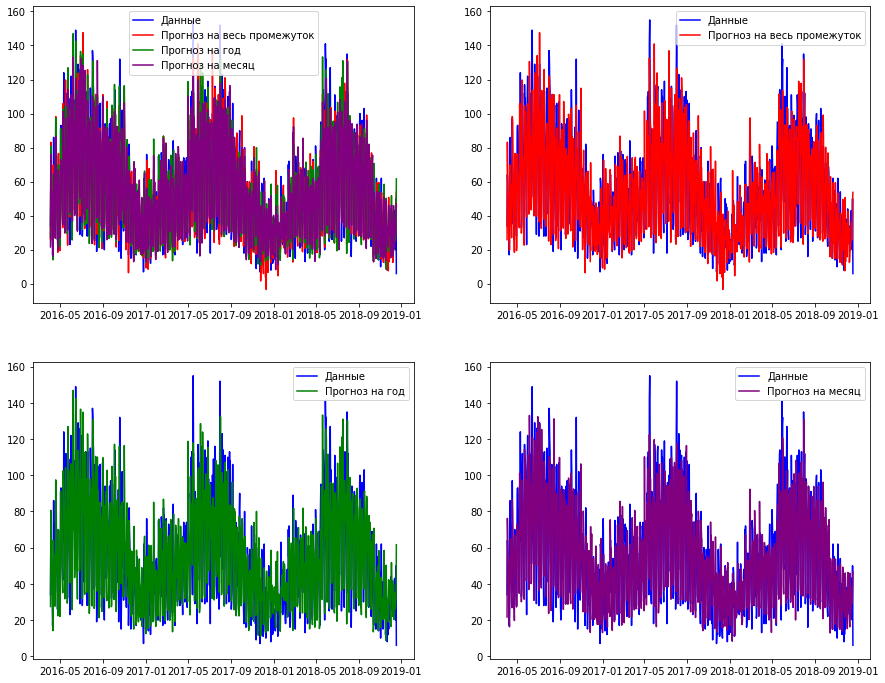

In [31]:
analyse(pd.DataFrame(pred_full, index=X_test.index),
        pd.DataFrame(pred, index=X_test.index),
        pd.DataFrame(pred_low, index=X_test.index))

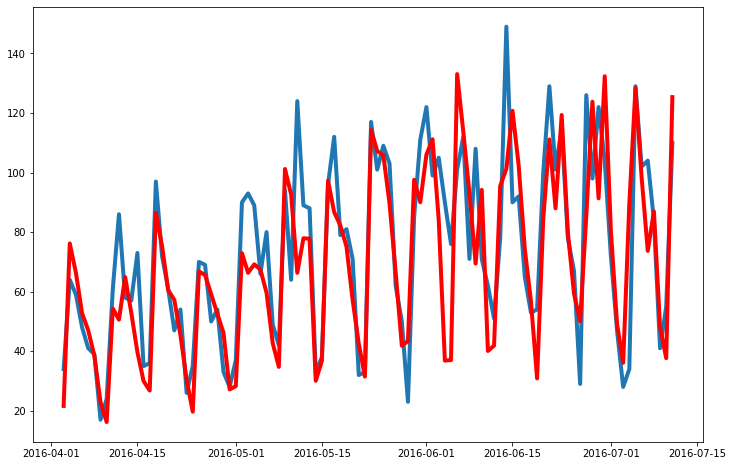

In [42]:
plt.figure(figsize=(12,8))
plt.plot(X_test[:100], lw=4)
plt.plot(pd.DataFrame(pred_low, index=X_test.index)[:100], color='red', lw=4)

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from pandas import read_csv
import math

from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow import random

np.random.seed(1)
random.set_seed(2)
num_features = 1

In [25]:
train_size = int(len(dataset) * 0.66)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

In [26]:
def to_supervised(dataset, seq_len):
  train_size = int(len(dataset) * 0.66)
  test_size = len(dataset) - train_size
  train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

  trainX, testX, trainY, testY = [], [], [], []
  for i in range(train_size - seq_len):
    trainX.append(train[i:i + seq_len, 0])
    trainY.append(train[i+seq_len, 0])

  for i in range(test_size):
    testX.append(dataset[train_size + i - seq_len: train_size + i, 0])
    testY.append(test[i, 0])

  trainX = np.array(trainX)
  testX = np.array(testX)
  trainY = np.array(trainY)
  testY = np.array(testY)
  trainX = np.reshape(trainX, (trainX.shape[0], seq_len, 1))
  testX = np.reshape(testX, (testX.shape[0], seq_len, 1))
  return trainX, trainY, testX, testY

In [27]:
seq_len = 18
trainX, trainY, testX, testY = to_supervised(dataset, seq_len)
dataX = np.concatenate((trainX, testX))
dataY = np.concatenate((trainY, testY))

In [28]:
def test_it(model, epochs = 100):
  model.fit(trainX, trainY, verbose=2, epochs=epochs)
  trainPredict = model.predict(trainX)
  trainPredict = scaler.inverse_transform(trainPredict)
  trainY_inverse = scaler.inverse_transform([trainY])

  return math.sqrt(mean_squared_error(trainY_inverse[0], trainPredict[:,0]))

In [30]:
def get_RNN_model():
  model = Sequential()
  model.add(SimpleRNN(128, input_shape=(seq_len, num_features), activation='relu', return_sequences=True)) #12
  model.add(SimpleRNN(128, activation='relu')) #12
  model.add(Dense(1))
  model.compile(loss='mean_squared_error', optimizer='adam', metrics = ['acc']) 
  return model

In [ ]:
%%time
count = 10
pred, score = predict_parts(get_RNN_model(), trainX, trainY, testX, testY, 365, 100)
pred_full, score = predict_full(get_RNN_model, trainX, trainY, testX, testY, count, 300)
pred_low, score = predict_parts(get_RNN_model(), trainX, trainY, testX, testY, 30, 50)

Корень среднеквадратичного отклонения при полном прогнозе: 18.14
Корень среднеквадратичного отклонения при прогнозе на год: 18.60
Корень среднеквадратичного отклонения при прогнозе на месяц: 18.01


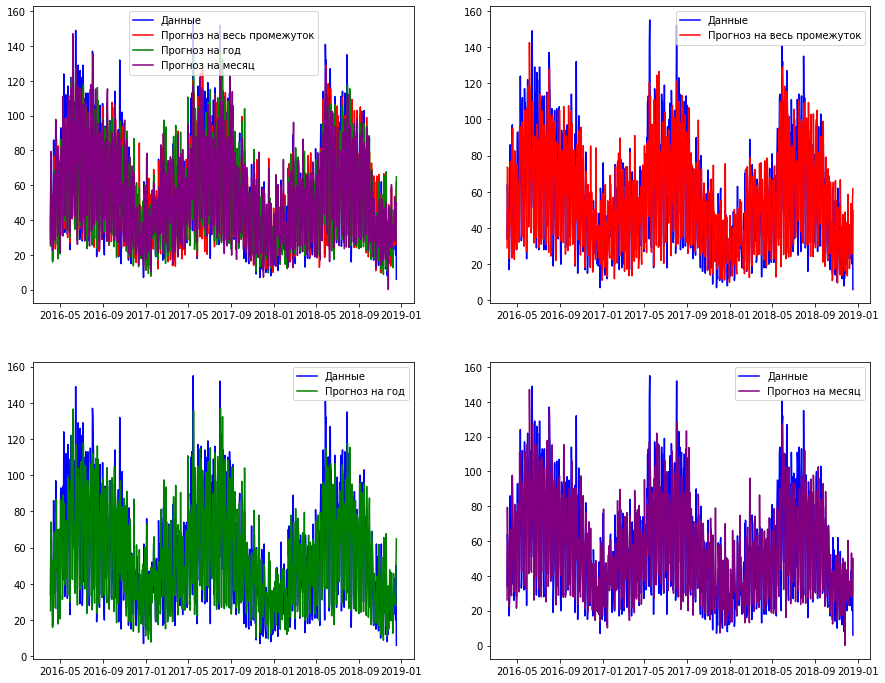

In [112]:
analyse(pd.DataFrame(pred_full, index=X_test.index),
        pd.DataFrame(pred, index=X_test.index),
        pd.DataFrame(pred_low, index=X_test.index))

In [32]:
def get_LSTM_model():
  model = Sequential()
  model.add(LSTM(128, input_shape=(seq_len, num_features),activation='relu', return_sequences=True))
  model.add(LSTM(128,activation='relu'))
  model.add(Dense(64))
  model.add(Dense(64))
  model.add(Dense(1))
  model.compile(optimizer = 'adam', loss='mse')
  return model

In [ ]:
seq_len = 20
trainX, trainY, testX, testY = to_supervised(dataset, seq_len)
dataX = np.concatenate((trainX, testX))
dataY = np.concatenate((trainY, testY))
test_it(get_LSTM_model(), 500)

Корень среднеквадратичного отклонения при полном прогнозе: 19.35
Корень среднеквадратичного отклонения при прогнозе на год: 20.12
Корень среднеквадратичного отклонения при прогнозе на месяц: 17.30
CPU times: user 78.5 ms, sys: 0 ns, total: 78.5 ms
Wall time: 74.9 ms


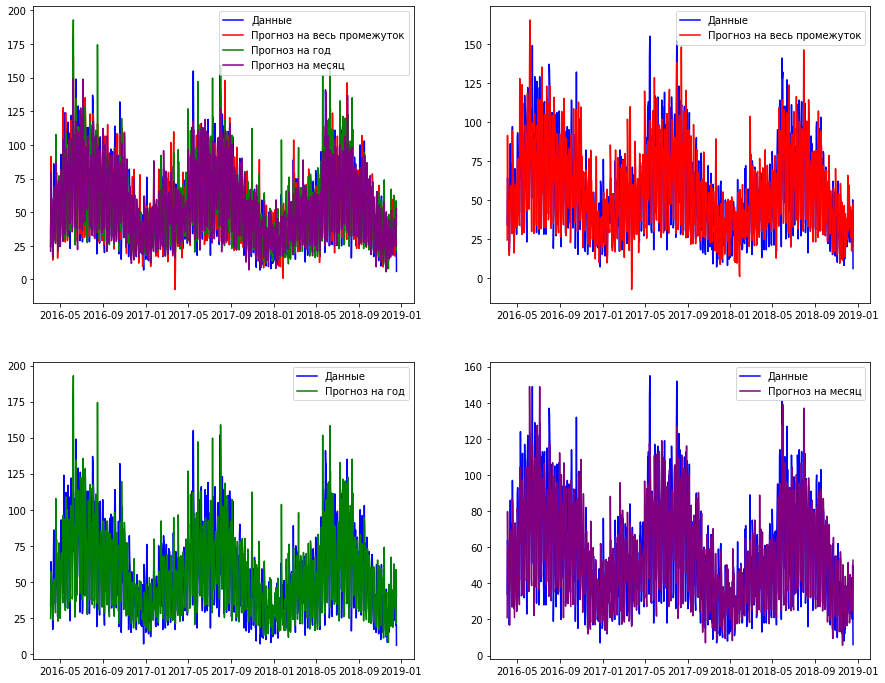

In [49]:
%%time
count = 10
pred, score = predict_parts(get_LSTM_model(), trainX, trainY, testX, testY, 12)
pred_full, score = predict_full(get_LSTM_model, trainX, trainY, testX, testY, count, 500)
pred_low, score = predict_parts(get_LSTM_model(), trainX, trainY, testX, testY, 1)

analyse(pd.DataFrame(pred_full, index=X_test.index),
        pd.DataFrame(pred, index=X_test.index),
        pd.DataFrame(pred_low, index=X_test.index))

In [ ]:
def test_and_plot(model, seq_len, epochs = 100):
  model.fit(trainX, trainY, verbose=0, epochs=epochs)
  trainPredict = model.predict(trainX)
  testPredict = model.predict(testX)

  trainPredict = scaler.inverse_transform(trainPredict)
  trainY_inverse = scaler.inverse_transform([trainY])
  testPredict = scaler.inverse_transform(testPredict)
  testY_inverse = scaler.inverse_transform([testY])

  trainScore = math.sqrt(mean_squared_error(trainY_inverse[0], trainPredict[:,0]))
  print('Train Score: %.2f RMSE' % (trainScore))

  testScore = math.sqrt(mean_squared_error(testY_inverse[0], testPredict[:,0]))
  print('Test Score: %.2f RMSE' % (testScore))

  trainPredictPlot = np.empty_like(dataset)
  trainPredictPlot[:, :] = np.nan
  trainPredictPlot[seq_len:len(trainPredict)+seq_len, :] = trainPredict

  testPredictPlot = np.empty_like(dataset)
  testPredictPlot[:, :] = np.nan
  testPredictPlot[len(trainPredict)+(seq_len):len(dataset), :] = testPredict


  plt.figure(figsize=(12,8))
  plt.plot(scaler.inverse_transform(dataset))
  plt.plot(trainPredictPlot)
  plt.plot(testPredictPlot)
  plt.show()

In [92]:
def predict_parts(model, trainX, trainY, testX, testY, window):
  dataX = np.concatenate((trainX, testX))
  dataY = np.concatenate((trainY, testY))

  parts_count = int(len(testY) / window)
  parts = []
  for i in range(parts_count):
    parts += [testX[i * window:(i + 1) * window]]
  if parts_count * window < len(testX):
    parts += [testX[parts_count * window:]]
  
  pred = np.empty((0, 1))

  for i in range(len(parts)):
    curr_len = len(trainX) + window * i
    prev_len = 0
    model.fit(dataX[prev_len:curr_len], dataY[prev_len:curr_len], verbose=0, epochs=3000)
    pred = np.concatenate(\
        (pred, model.predict(dataX[curr_len:curr_len + min(window, len(dataX) - curr_len)])))
    prev_len = curr_len
  testPredict = scaler.inverse_transform(pred)
  testY_inverse = scaler.inverse_transform([testY])

  testScore = math.sqrt(mean_squared_error(testY_inverse[0], testPredict[:,0]))
  return testPredict, testScore



In [93]:
def predict_full(get_model, trainX, trainY, testX, testY, count):
  pred = np.zeros((len(testY), 1))
  for i in range(count):
    model = get_model()
    model.fit(trainX, trainY, verbose=0, epochs=3000)
    pred += model.predict(testX)

  testPredict = pred / count
  testPredict = scaler.inverse_transform(testPredict)
  testY_inverse = scaler.inverse_transform([testY])

  testScore = math.sqrt(mean_squared_error(testY_inverse[0], testPredict[:,0]))
  return testPredict, testScore

In [54]:
data = pd.read_csv('drive/MyDrive/Colab Notebooks/311-requests.tsv', '\t')
data = data.groupby('Creation Date', as_index=False).agg('count')\
    .rename({'Status': 'Count'}, axis=1)[['Count', 'Creation Date']]
data['Creation Date'] = data['Creation Date'].apply(lambda x: x[:10])
data['Date'] = pd.to_datetime(data['Creation Date'])
dates = data['Creation Date']
data = data.drop('Creation Date', axis=1)
data.set_index('Date', inplace=True)

offset = 41
data = data[offset:]

In [86]:
dataset = data['Count'].values.astype('float32').reshape((len(data), 1))
trainX, trainY, testX, testY = to_supervised(dataset, 50)
trainX, testX = trainX[:,:,0], testX[:,:,0]

In [87]:
def predict_parts_RF(model, trainX, trainY, testX, testY, window):
  dataX = np.concatenate((trainX, testX))
  dataY = np.concatenate((trainY, testY))

  parts_count = int(len(testY) / window)
  parts = []
  for i in range(parts_count):
    parts += [testX[i * window:(i + 1) * window]]
  if parts_count * window < len(testX):
    parts += [testX[parts_count * window:]]
  
  pred = np.empty((0))

  for i in range(len(parts)):
    curr_len = len(trainX) + window * i
    prev_len = 0
    model.fit(dataX[prev_len:curr_len], dataY[prev_len:curr_len])
    pred = np.concatenate(\
        (pred, model.predict(dataX[curr_len:curr_len + min(window, len(dataX) - curr_len)])))
    prev_len = curr_len

  testScore = math.sqrt(mean_squared_error(testY, pred))
  return pred, testScore

In [88]:
def predict_full_RF(model, trainX, trainY, testX, testY):
  model.fit(trainX, trainY)
  pred = model.predict(testX)
  testScore = math.sqrt(mean_squared_error(testY, pred))
  return pred, testScore

In [89]:
from sklearn.ensemble import RandomForestRegressor
def get_RF_model():
  return RandomForestRegressor()

Корень среднеквадратичного отклонения при полном прогнозе: 15.49
Корень среднеквадратичного отклонения при прогнозе на год: 15.61
Корень среднеквадратичного отклонения при прогнозе на месяц: 15.50


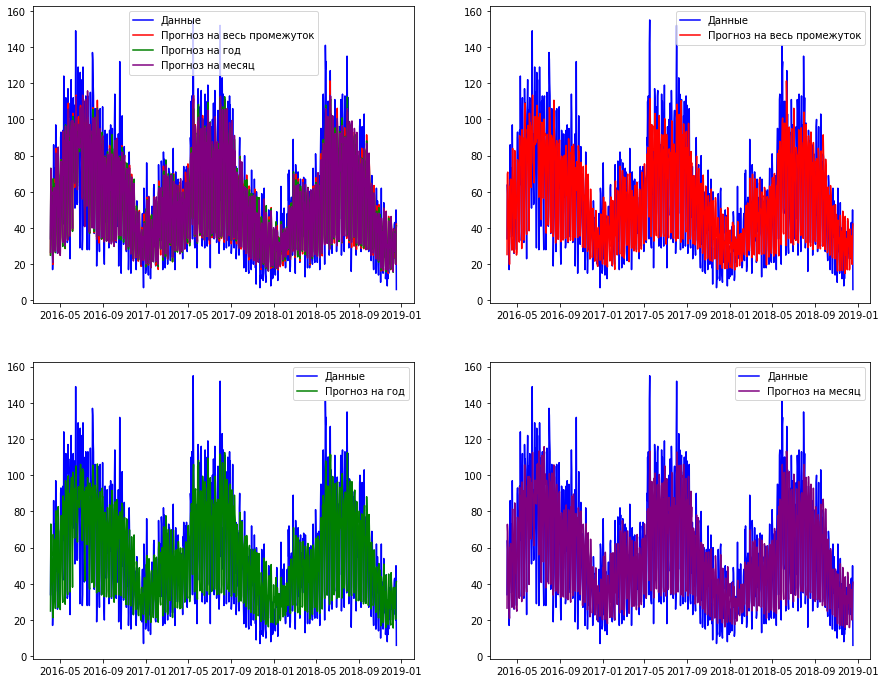

In [94]:
full, score = predict_full_RF(get_RF_model(), trainX, trainY, testX, testY)
mid, score = predict_parts_RF(get_RF_model(), trainX, trainY, testX, testY, 365)
low, score = predict_parts_RF(get_RF_model(), trainX, trainY, testX, testY, 30)

analyse(pd.DataFrame(full, index=X_test.index),
        pd.DataFrame(mid, index=X_test.index),
        pd.DataFrame(low, index=X_test.index))

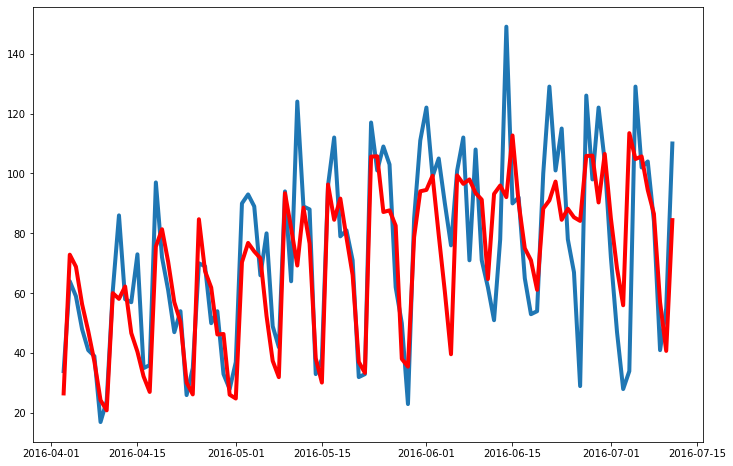

In [95]:
plt.figure(figsize=(12,8))
plt.plot(X_test[:100], lw=4)
plt.plot(pd.DataFrame(low, index=X_test.index)[:100], color='red', lw=4)